In [248]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import torch
import pandas as pd
import seaborn as sns
import random
import numpy as np
from IPython import display
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as  transforms
import torch.optim as optim

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [257]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
trainset = datasets.FashionMNIST('.', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testset = datasets.FashionMNIST('.', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=False, num_workers=2)

In [250]:
def plot_images(images, labels, predicted = None, ROW = 3, COLUMN = 5):
    plt.figure(figsize=(COLUMN * 2,ROW * 2))
    for i in range(ROW * COLUMN):
        image = images[i].reshape(28, 28)
        plt.subplot(ROW, COLUMN, i+1)
        plt.imshow(image, cmap='gray')
        if predicted is not None:
            plt.title('real:{}\npred:{}'.
                      format(convertlabel[labels[i].item()], convertlabel[predicted[i].item()]))
        else:
            plt.title('real:{}'.format(convertlabel[labels[i].item()]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [251]:
import math
def visualize(loss,  scale=100, ROW=1): 
    COLUMN =  math.ceil(len(loss) // ROW)
    plt.figure(figsize=(COLUMN * 5, ROW * 5))
    for i in range(ROW * COLUMN):
        plt.subplot(ROW, COLUMN, i+1)       
        plt.plot(np.arange(len(loss[i, :])), loss[i])
        plt.xticks(np.arange(0, len(loss[i, :]), 5), 5 * np.arange(0, len(loss[i, :]), 5))
        plt.grid()
        plt.title('epoch ' + str(i))
    plt.tight_layout()
    plt.show()   


In [252]:
X_train, y_train = trainset.train_data, trainset.train_labels
X_test, y_test = testset.test_data, testset.test_labels

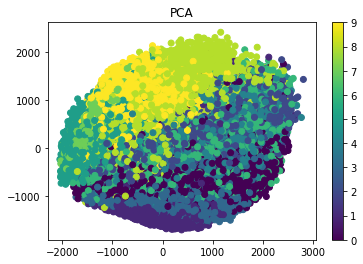

In [253]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_res = pca.fit_transform(X_train.reshape(60000, 28 * 28))
data = pd.DataFrame({'x': pca_res[:, 0] , 'y': pca_res[:, 1], 'label': y_train})
plt.scatter(pca_res[:, 0], pca_res[:, 1], c=y_train )
plt.colorbar()
plt.title('PCA')
plt.show()


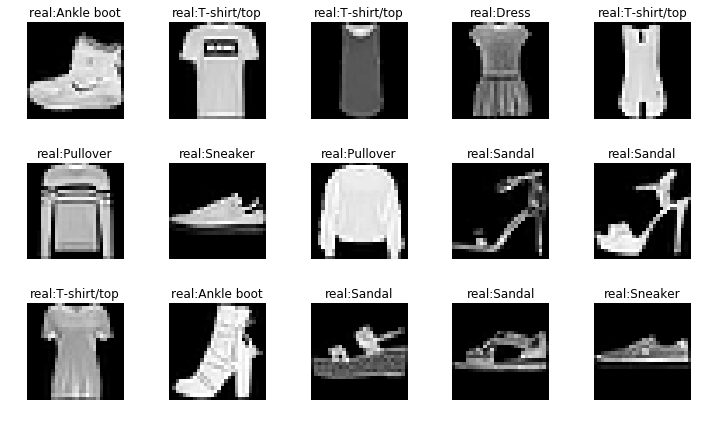

In [254]:
plot_images(X_train, y_train)

In [255]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Finished Training
epoch: 2
accuracy on test 0.8723


loss function:


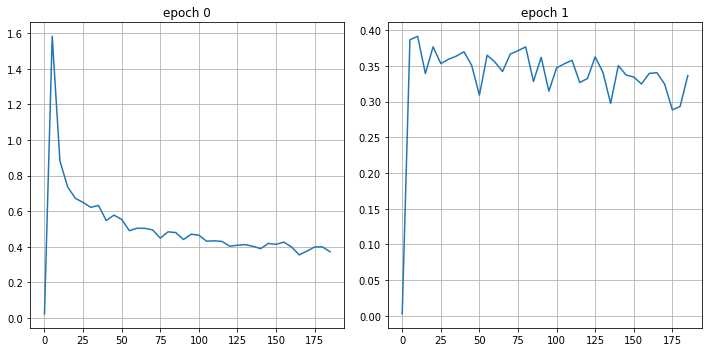

In [265]:
random.seed(100)
torch.manual_seed(100)
n_epoch = 2
n_iter = len(trainloader)

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_arr = np.zeros((n_epoch, n_iter // 100 + 1))
for epoch in range(n_epoch):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            loss_arr[epoch, i // 100] = running_loss / 100
            print( 'epoch {}/{} process {}%   loss: {} '.
                  format(epoch + 1, n_epoch,i * 100 // n_iter, round(running_loss / 100, 3)))
            running_loss = 0.0
            display.clear_output(wait=True)
print('Finished Training')

print('epoch:', n_epoch)
images, labels = iter(testloader).next()
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
print('accuracy on test', (predicted == labels).sum().item()/ len(labeles), end='\n\n\n')

print('loss function:')
visualize(loss_arr, scale=100)


#### Точность для каждого класса

In [151]:
for cls in range(10):
    cond = labels == cls
    cls_labels = labeles[cond]
    pred_labels = predicted[cond]
    print('class {}: accuracy {}'.
          format(convertlabel[cls],(pred_labels == cls_labels).sum().item()/ len(cls_labels)))

class T-shirt/top: accuracy 0.861
class Trouser: accuracy 0.972
class Pullover: accuracy 0.771
class Dress: accuracy 0.873
class Coat: accuracy 0.859
class Sandal: accuracy 0.964
class Shirt: accuracy 0.652
class Sneaker: accuracy 0.951
class Bag: accuracy 0.974
class Ankle boot: accuracy 0.949


#### Неправильно предсказынные

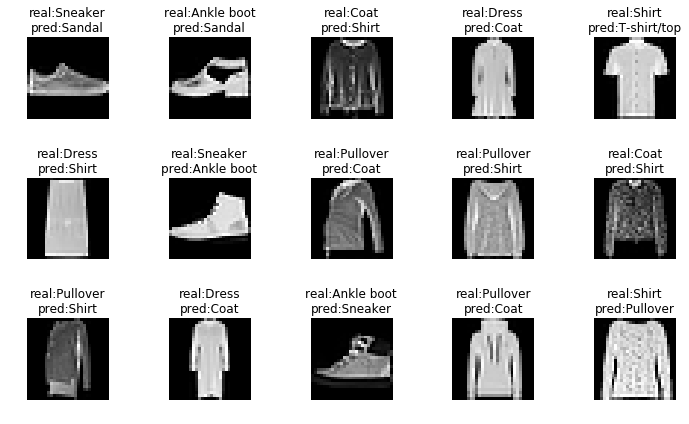

In [158]:
errors = labels != predicted
plot_images(images[errors], labels[errors], predicted[errors])